In [3]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import numpy as np
import seaborn as sb
import spiceypy as spice
import pickle
from scipy.spatial.transform import Rotation

from datetime import datetime, timedelta
from pathlib import Path

In [5]:
from lropy.analysis.spice_tools import as_et, as_utc, as_tdb, generate_lro_ephemeris, init_spice_bepicolombo
from lropy.analysis.io import load_simulation_results, pos_names, acc_names, irr_names, panels_count_names, load_pickled_simulation_results
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.transform import spher2cart, cart2spher, align_vectors
from lropy.analysis.util import get_day_index
from lropy.constants import c

In [6]:
init_spice_bepicolombo()

In [7]:
def get_mpo_orbital_plane_normal(t):
    pos1 = spice.spkezr("MPO", t, "ECLIPJ2000", "NONE", "Mercury")[0][3:]
    # Quarter of a period later
    pos2 = spice.spkezr("MPO", t + 8355 / 4, "ECLIPJ2000", "NONE", "Mercury")[0][3:]
    normal = np.cross(pos1, pos2)
    return normal / np.linalg.norm(normal)


def get_mpo_beta_angle(t):
    normal = get_mpo_orbital_plane_normal(t)

    sun_pos = spice.spkezr("Sun", t, "ECLIPJ2000", "NONE", "Mercury")[0][:3]
    sun_dir = sun_pos / np.linalg.norm(sun_pos)

    beta_angle = np.degrees(np.arccos(sun_dir @ normal)) - 90
    return beta_angle

# BepiColombo 1 year

In [9]:
# df = load_pickled_simulation_results("../results/mpo_1year_initialkepler")  # initial state from Kepler elements
# df = load_pickled_simulation_results("../results/mpo_1year_initialkepler_flip")  # flipped nodes
df = load_pickled_simulation_results("../results/mpo_1year")  # initial state from SPK

In [10]:
df_noeclip = load_pickled_simulation_results("../results/mpo_1year_noeclip")  # initial state from SPK, occultation disabled

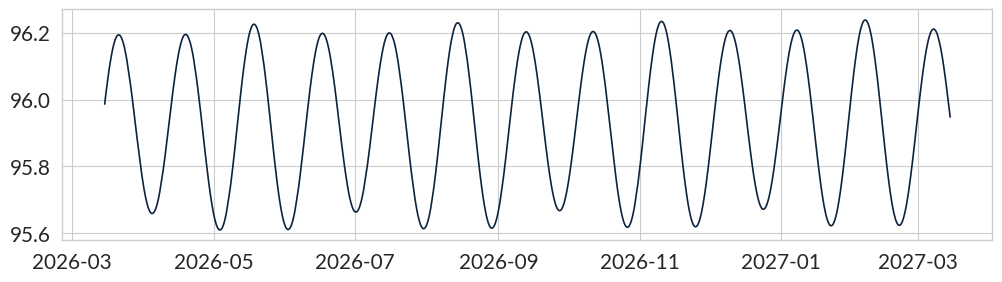

In [11]:
plt.plot(np.degrees(df["kepler_i"]))

In [12]:
r_peri = df["r_sun"].min()
r_ap = df["r_sun"].max()
f"Semi-major axis: {(r_peri + r_ap) / 2e3:.2f} km", f"Eccentricity: {(r_ap - r_peri) / (r_ap + r_peri):.3f}"

('Semi-major axis: 57909028.06 km', 'Eccentricity: 0.206')

Expected SRP acceleration average magnitude at perihelion:

In [13]:
sun_luminosity = 3.828e26  # W
solar_irradiance = sun_luminosity / (4 * np.pi * r_peri**2)
1.9e-2 * solar_irradiance / c * 0.79

7.207632135638257e-07

(0.79 is illuminated fraction of orbit, i.e. 0.21 of orbit is spent in eclipse)

Expected SRP acceleration average magnitude at aphelion:

In [14]:
sun_luminosity = 3.828e26  # W
solar_irradiance = sun_luminosity / (4 * np.pi * r_ap**2)
1.9e-2 * solar_irradiance / c * 0.71

2.812074897635476e-07

In [15]:
def plot_solar_geom(df):
    orbits_per_day = 86400 / 8355
    day_spacing = 3

    df = df[["r_sun", "angle_subsolar"]]
    df = df.rolling(360, min_periods=1).mean().iloc[::int(360 * day_spacing * orbits_per_day)].iloc[1:]
    idx = (df.index - df.index[0]).days

    fig, (ax_r, ax_subsol) = plt.subplots(2, figsize=(12, 5), sharex=True)

    ax_r.plot(idx, df["r_sun"] / 1e3)
    ax_r.set_title("Solar distance [km]")
    
    ax_subsol.plot(idx, df["angle_subsolar"])
    ax_subsol.set_title("Subsolar angle")

    format_plot()

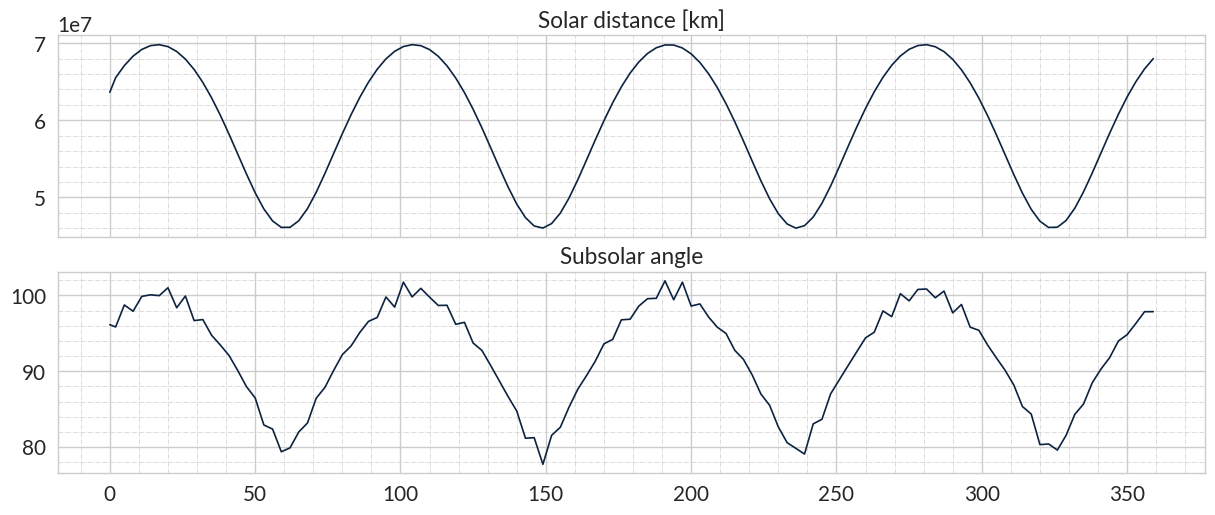

In [16]:
plot_solar_geom(df)

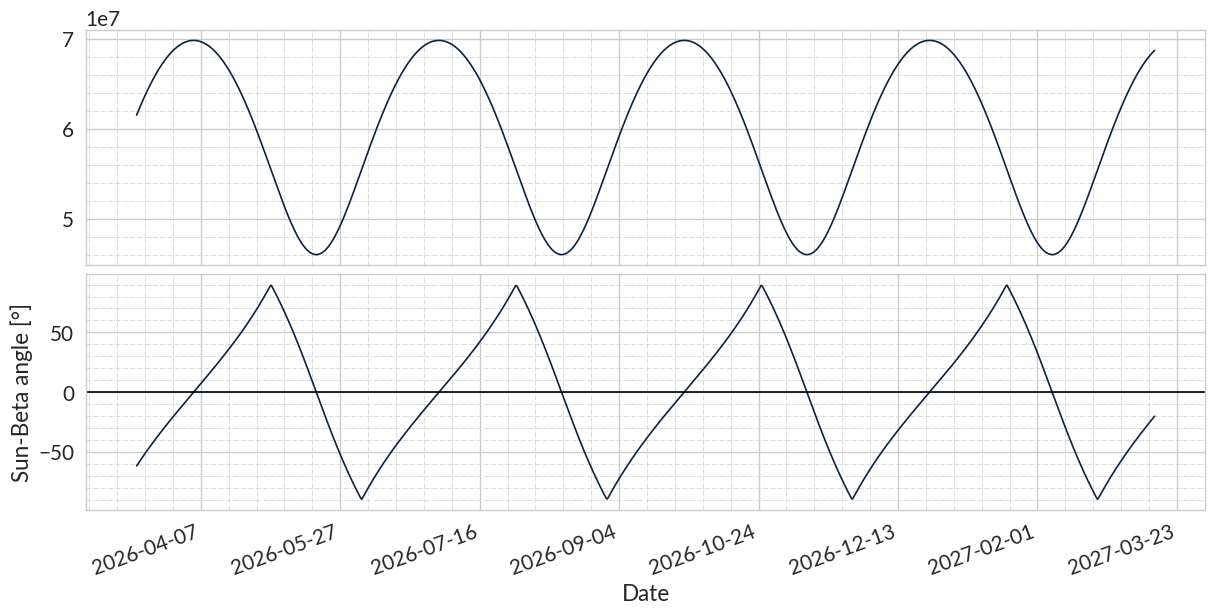

In [17]:
def plot_beta_angle():
    fig, (ax_dist, ax_ang) = plt.subplots(2, figsize=(12, 6), sharex=True)

    t_start = as_et("2026 MAR 15")
    days = 365
    tt = np.linspace(t_start, t_start + days * 24 * 3600, 1000)
    dates = pd.to_datetime([as_utc(t, sec_prec=6) for t in tt])

    ax_dist.plot(dates, np.vectorize(lambda t: np.linalg.norm(spice.spkpos("Sun", t, "ECLIPJ2000", "NONE", "Mercury")[0]))(tt))

    ax_ang.plot(dates, np.vectorize(get_mpo_beta_angle)(tt))

    ax_ang.axhline(0, c="black")

    ax_ang.set_xlabel("Date")
    ax_ang.set_ylabel("Sun-Beta angle [°]")

    plt.xticks(rotation=20, ha='right')
    ax_ang.set_yticks(np.arange(-90, 91, 30))

    format_plot()

plot_beta_angle()

Perihelion from SPK does indeed coincide with beta = 0 deg, as expected (https://www.cosmos.esa.int/web/bepicolombo/mpo). Unsure if this is also the case for kepler-based initial state.

In [69]:
def plot_solar_acc(df, component="radial"):
    orbits_per_day = 86400 / 8355
    day_spacing = 15
    if component == "magnitude":
        col = "acc_rp_sun"
    else:
        col = f"acc_rp_sun_{component}"
    df = df[[col]]
    df = df.rolling(360, min_periods=1).mean().iloc[::int(360 * day_spacing * orbits_per_day)].iloc[1:]

    fig, (ax_time, ax_freq) = plt.subplots(2, figsize=(12, 5))
    ax_time.plot(get_day_index(df), df[col])
    # ax_time.set_xlim([64, 65])  # perihelion
    # ax_time.set_xlim([107.5, 108.5])  # aphelion

    amps = np.absolute(np.fft.rfft(df[col]))
    freqs = np.fft.rfftfreq(len(df.index), d=day_spacing)
    ax_freq.plot(freqs, amps)
    ax_freq.set_xlim([0, 0.04])

    fig.suptitle(component)
    format_plot()

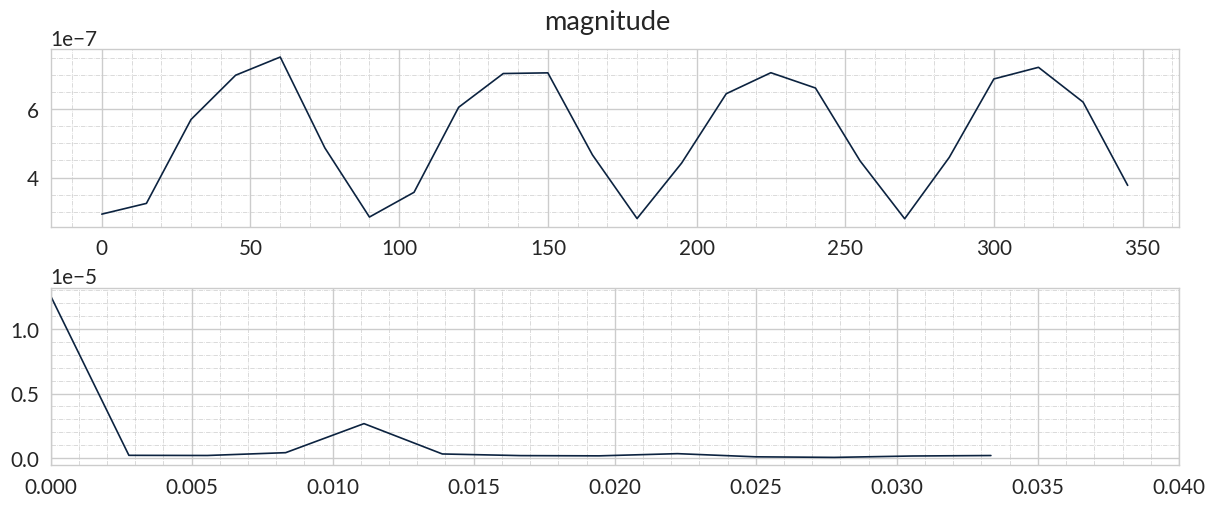

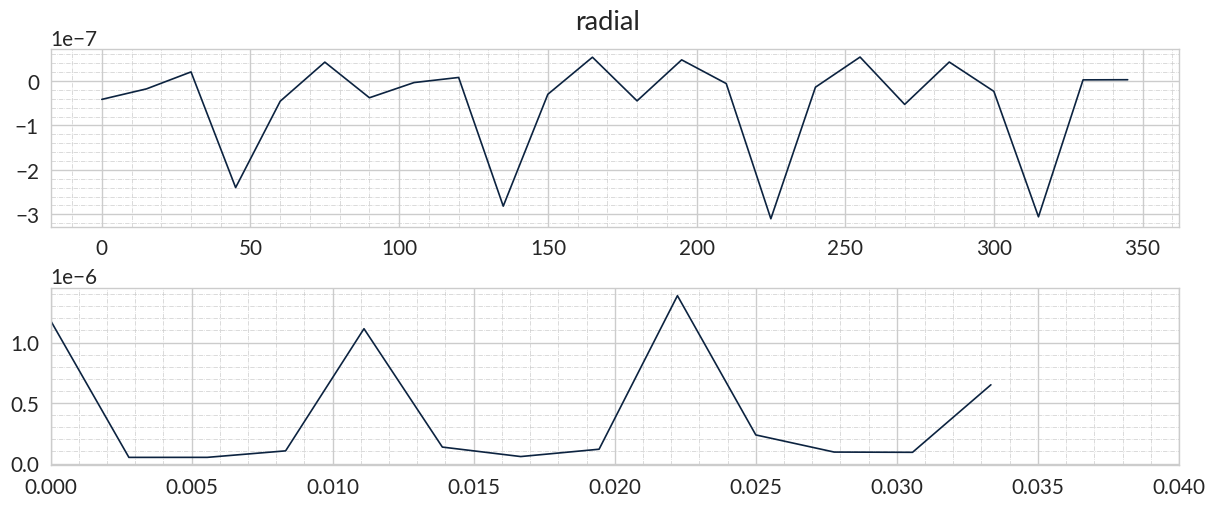

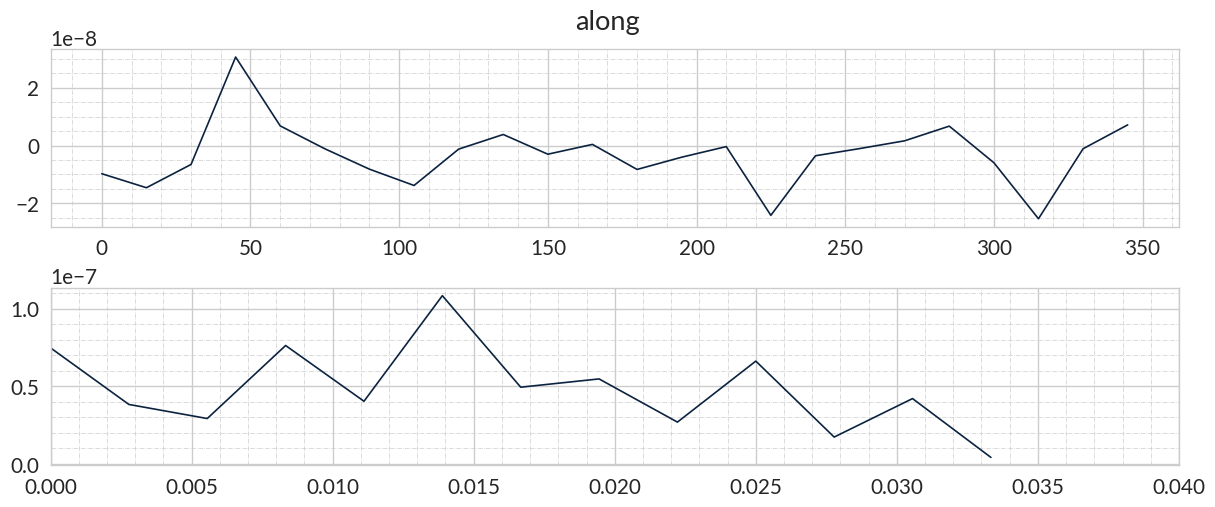

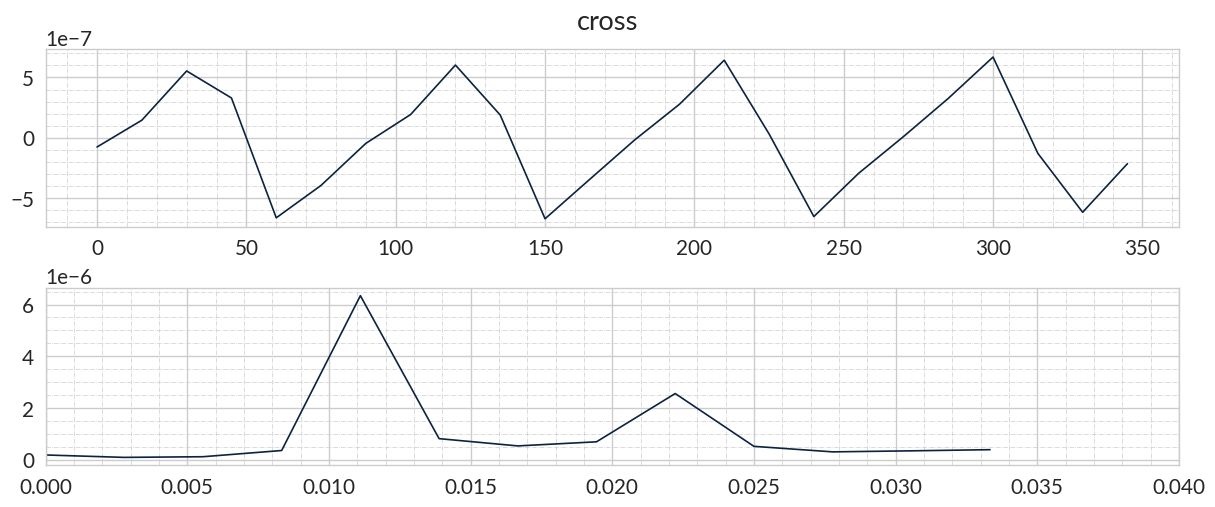

In [70]:
plot_solar_acc(df, "magnitude")
plot_solar_acc(df, "radial")
plot_solar_acc(df, "along")
plot_solar_acc(df, "cross")

Solar RP Results:
* Note that orbit is probably not quite the same as Lucchesi 2006
* Total magnitude has proper magnitude (2.3x higher at perihelion as dictated by inverse square law)
* Cross-track is assymetric due to eccentricity of Mercury's orbit: it spends much less time close to perihelion than close to aphelion.
* Radial and along-track magnitude agrees with paper, cross-track magnitude is slightly too low
* Intermediate peak (period 44 days) of radial acc is lower in magnitude, but our results seem correct after analytical calculations and closer inspection

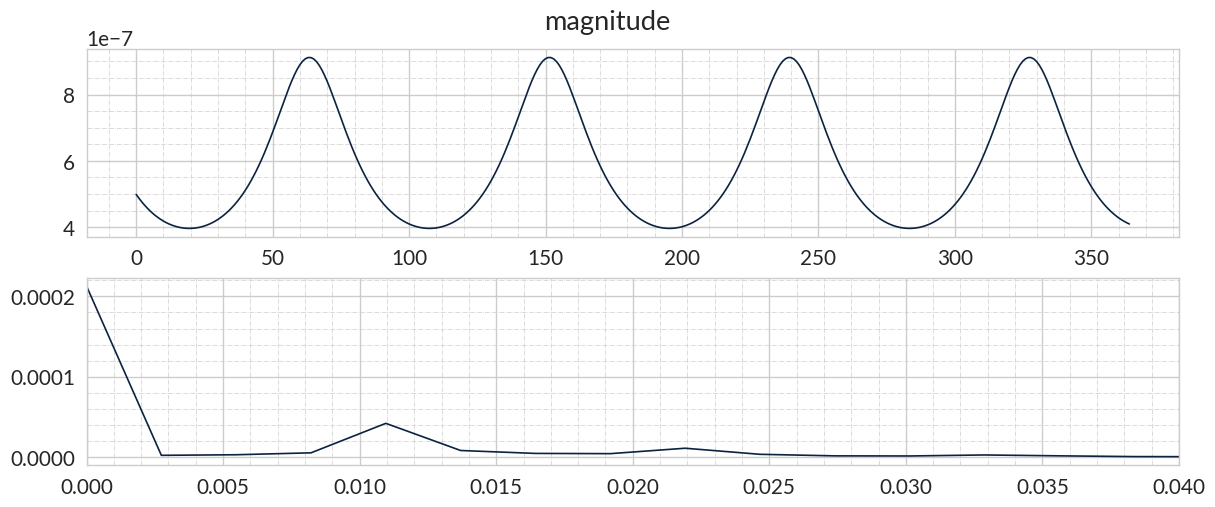

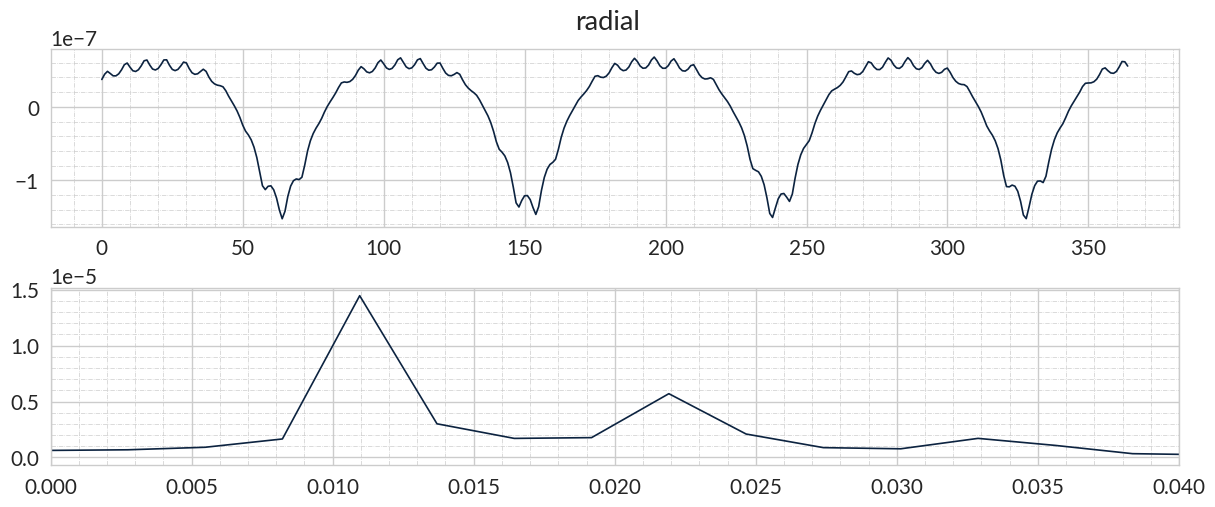

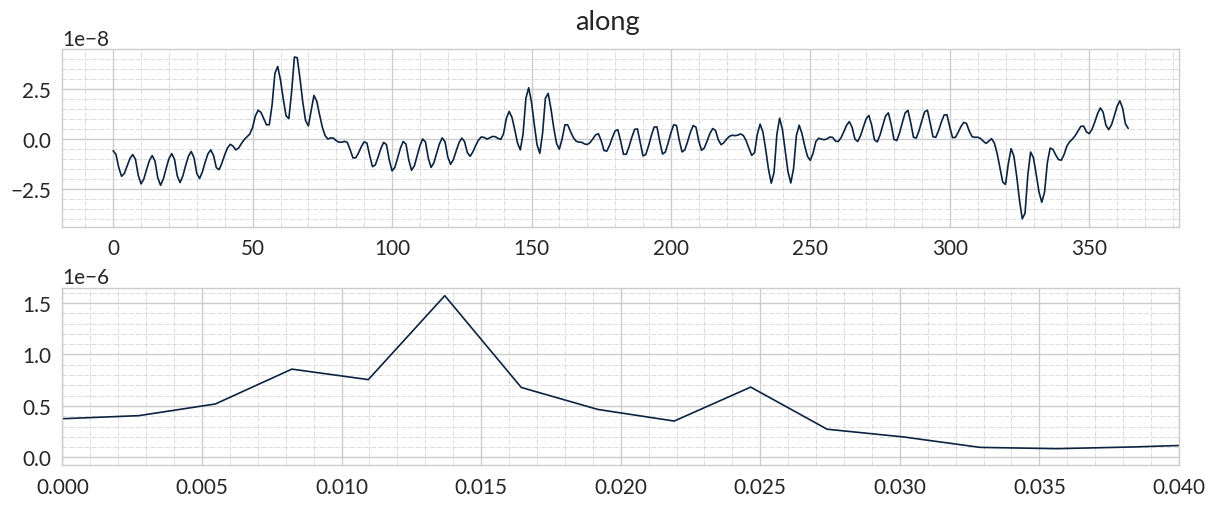

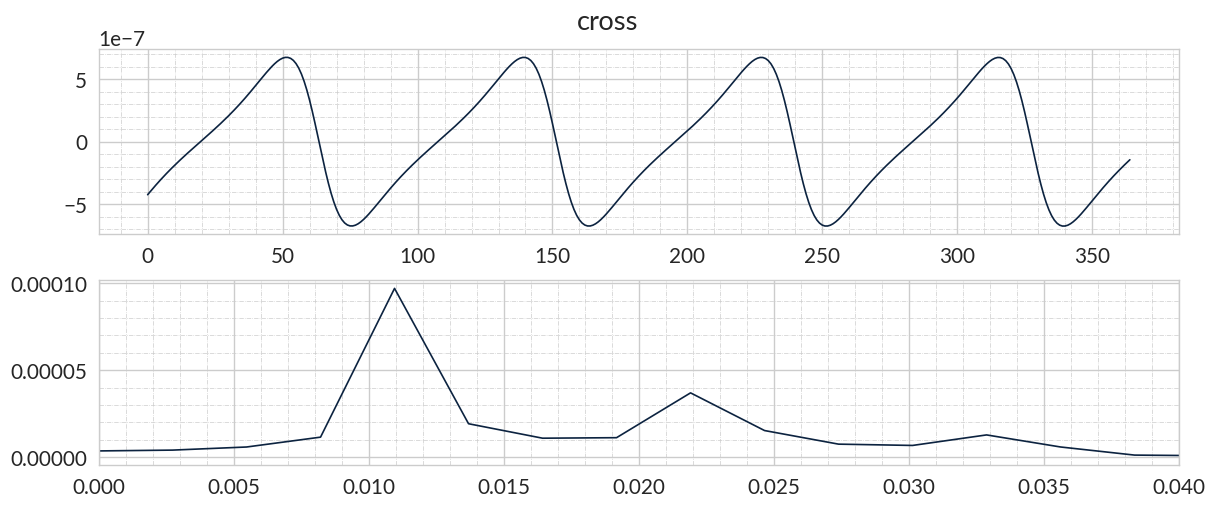

In [20]:
plot_solar_acc(df_noeclip, "magnitude")
plot_solar_acc(df_noeclip, "radial")
plot_solar_acc(df_noeclip, "along")
plot_solar_acc(df_noeclip, "cross")

In [21]:
def plot_mercury_acc(df, component="radial"):
    orbits_per_day = 86400 / 8355
    day_spacing = 15

    if component == "magnitude":
        col = "acc_rp_mercury"
    else:
        col = f"acc_rp_mercury_{component}"
    df = df[[col]]
    df = df.rolling(360, min_periods=1).mean().iloc[::int(360 * day_spacing * orbits_per_day)].iloc[1:]

    fig, (ax_time, ax_freq) = plt.subplots(2, figsize=(12, 5))
    ax_time.plot(get_day_index(df), df[col])
    # ax_time.set_xlim([64, 65])  # perihelion
    # ax_time.set_xlim([107, 109])  # aphelion

    amps = np.absolute(np.fft.rfft(df[col]))
    freqs = np.fft.rfftfreq(len(df.index), d=day_spacing)
    ax_freq.plot(freqs, amps)
    ax_freq.set_xlim([0, 0.04])

    fig.suptitle(component)
    format_plot()

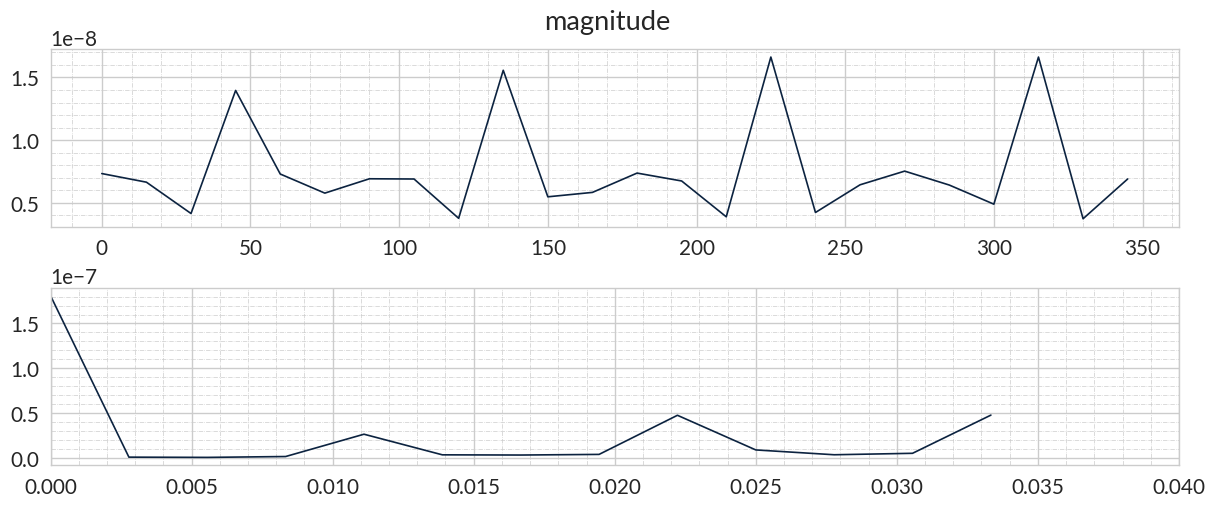

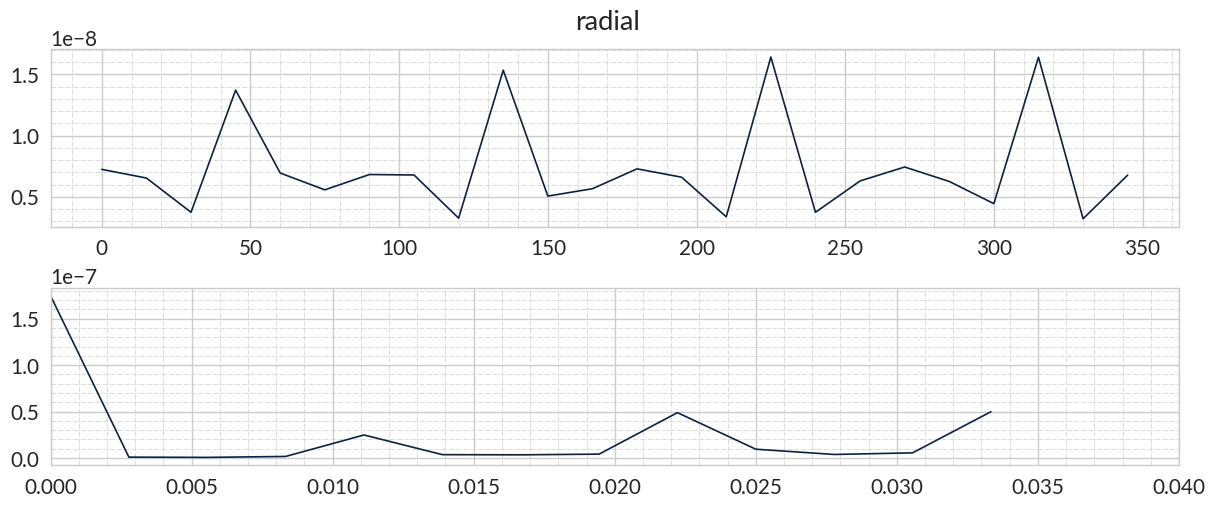

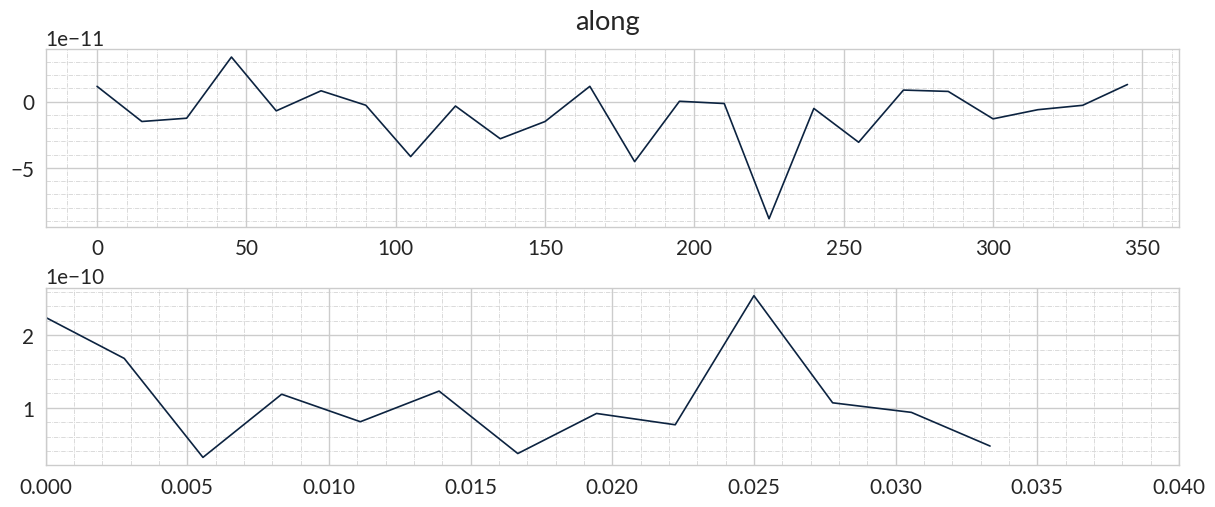

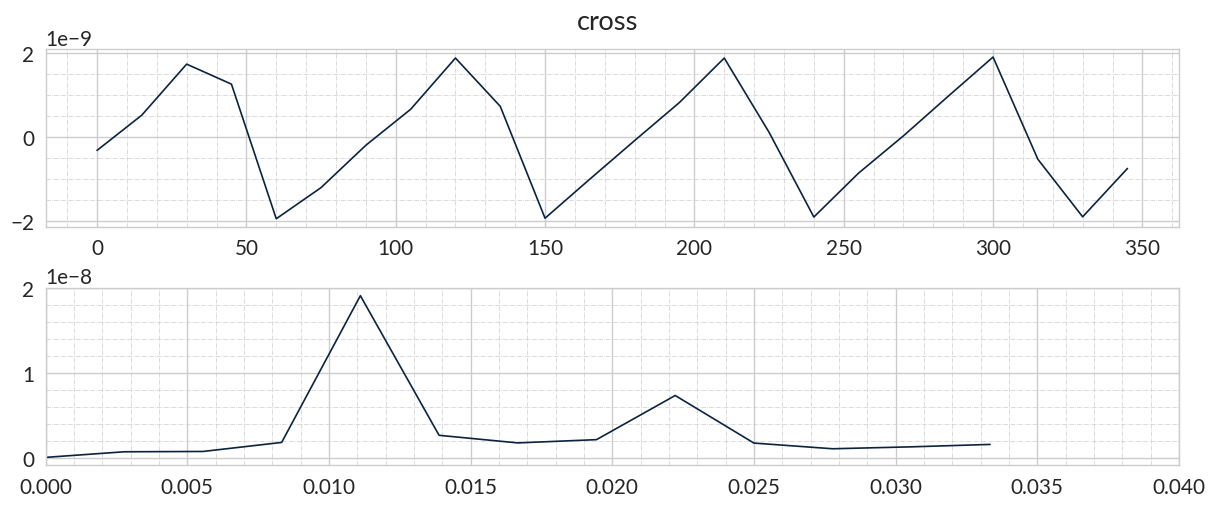

In [22]:
plot_mercury_acc(df, "magnitude")
plot_mercury_acc(df, "radial")
plot_mercury_acc(df, "along")
plot_mercury_acc(df, "cross")

Albedo RP results:
* Radial magnitude agrees, but intermediate peak is missing (same for total magnitude), just like from solar radial
* Along-track magnitude is 3 orders too high, but maybe due to higher-resolution paneling
* Cross-track agrees perfectly in magnitude and pattern

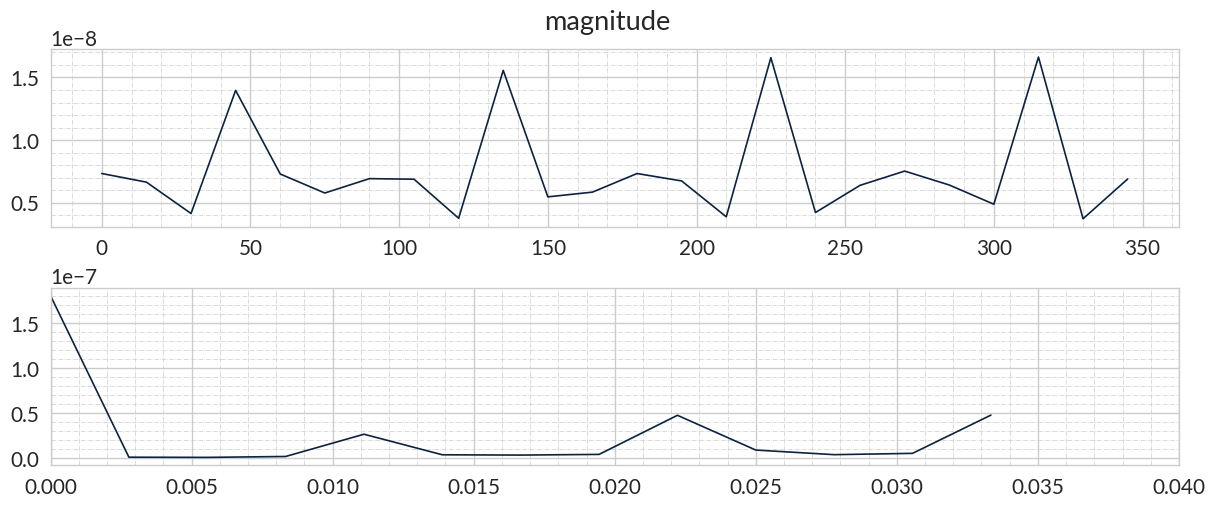

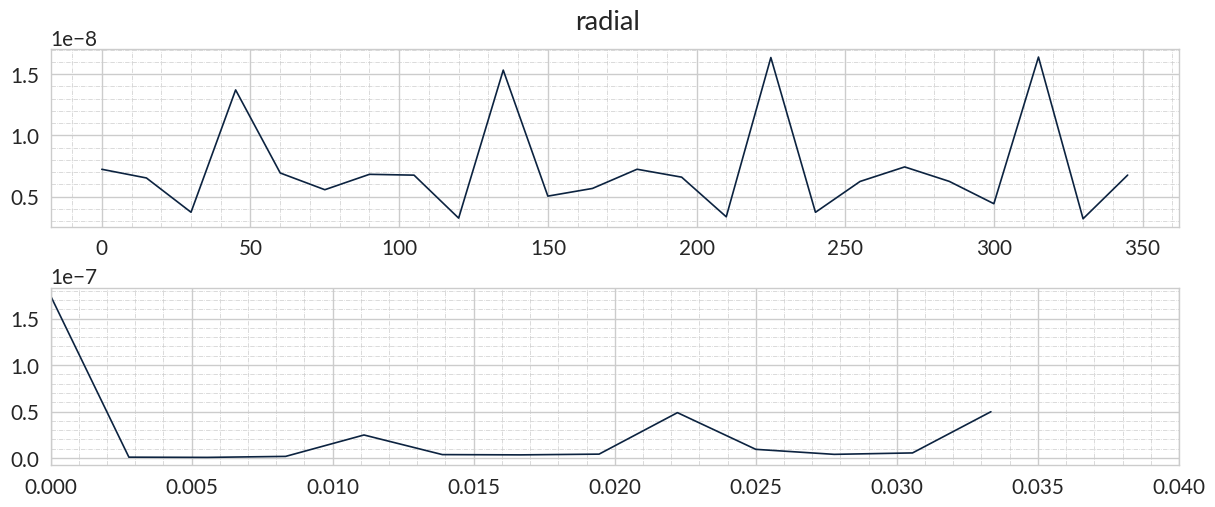

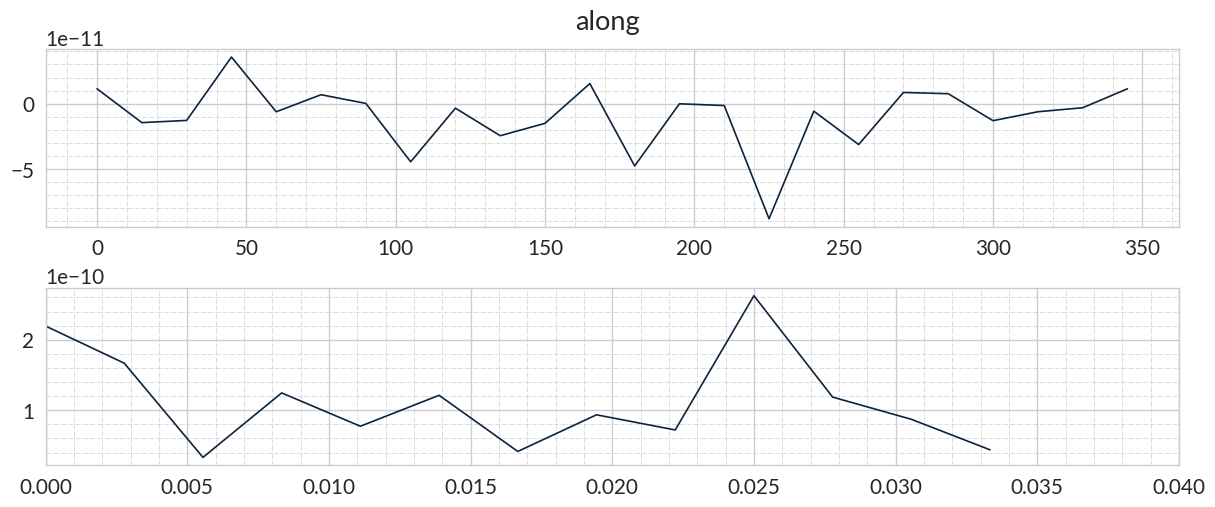

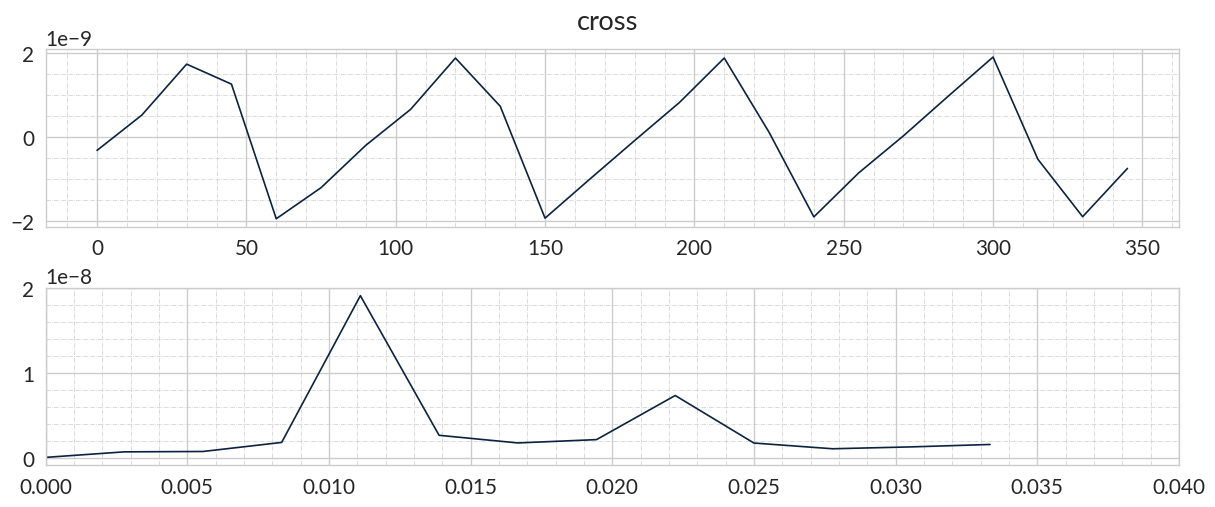

In [23]:
plot_mercury_acc(df_noeclip, "magnitude")
plot_mercury_acc(df_noeclip, "radial")
plot_mercury_acc(df_noeclip, "along")
plot_mercury_acc(df_noeclip, "cross")

# BepiColombo 13 years

In [24]:
df_long = load_pickled_simulation_results("../results/mpo")

In [25]:
def run_on_server():
    tt = []
    for start in range(0, len(df.index), int(360 * day_spacing * orbits_per_day)):
        tt.extend([start + i for i in range(360)])
    df = df.iloc[tt].copy()
    df = _enhance_df(df)

In [26]:
def plot_sun_acc_long(df, component="radial", trim_years=None):
    orbits_per_day = 86400 / 8355
    day_spacing = 15

    col = f"acc_rp_sun_{component}"
    col_mean = f"{col}_mean"
    df = df[[col]].copy()
    df.loc[:, col_mean] = np.nan
    col_mean_loc = df.columns.get_loc(col_mean)

    for start in range(0, len(df.index), 360):
        df.iat[start, col_mean_loc] = df.iloc[start:start+360].mean().mean()
    df = df.iloc[::360]
    
    if trim_years is not None:
        df = df.iloc[:int(trim_years * 365 / day_spacing)]

    fig, (ax_time, ax_freq) = plt.subplots(2, figsize=(12, 5))
    ax_time.plot(get_day_index(df), df[col_mean])

    amps = np.absolute(np.fft.rfft(df[col]))
    freqs = np.fft.rfftfreq(len(df.index), d=day_spacing)
    ax_freq.plot(freqs, amps)
    ax_freq.set_xlim([0, 0.04])

    fig.suptitle(component)
    format_plot()

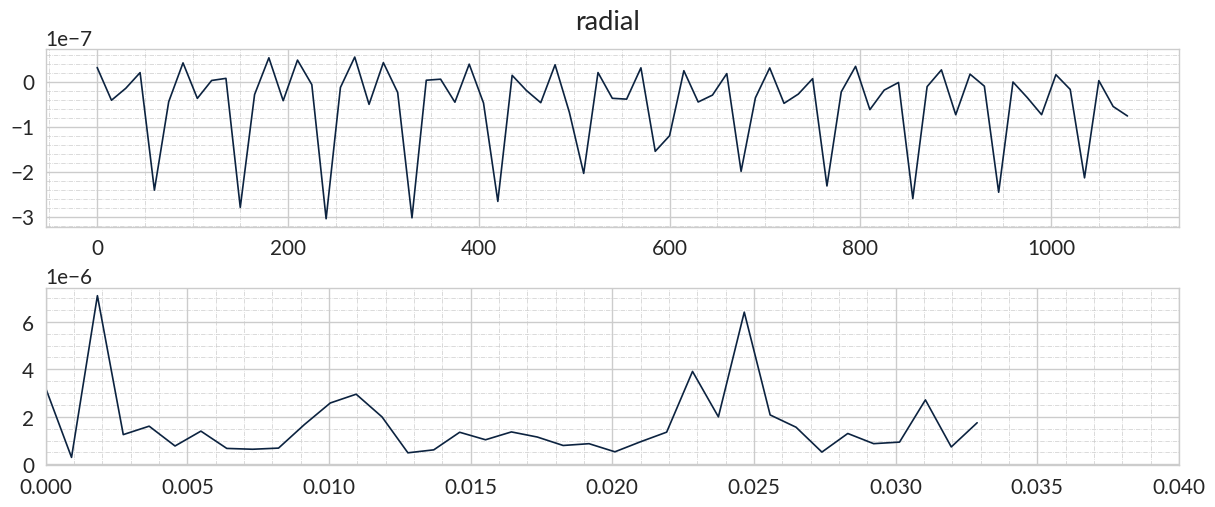

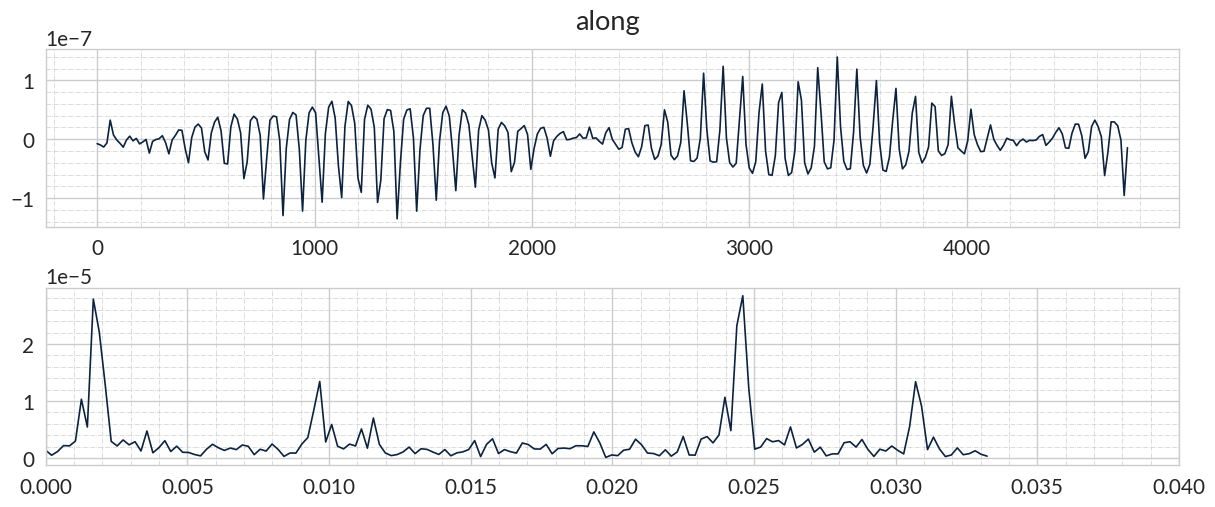

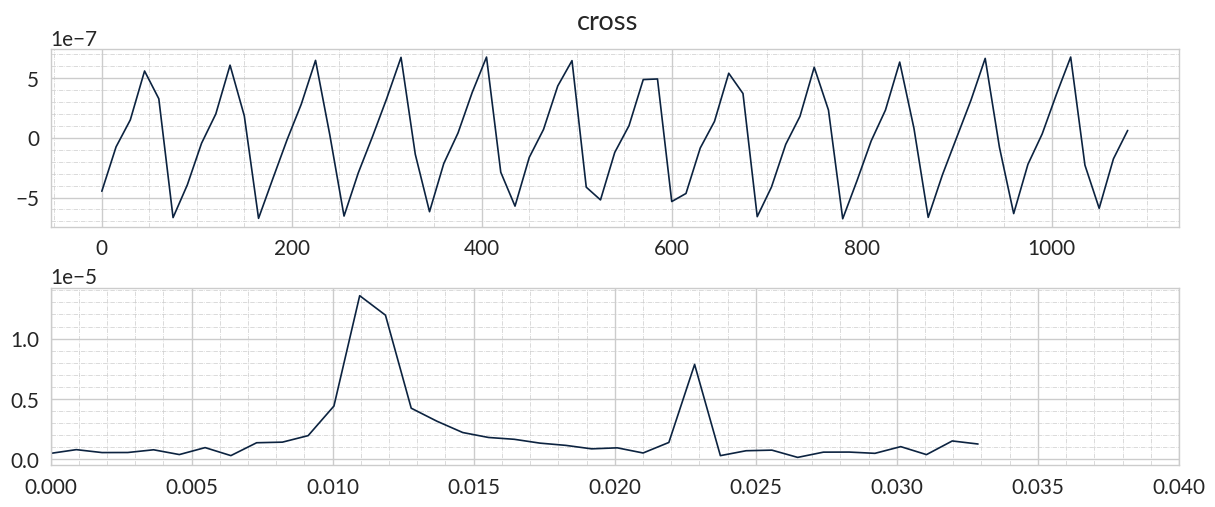

In [27]:
plot_sun_acc_long(df_long, "radial", trim_years=3)
plot_sun_acc_long(df_long, "along")
plot_sun_acc_long(df_long, "cross", trim_years=3)

In [28]:
def plot_mercury_acc_long(df, component="radial", trim_years=None):
    orbits_per_day = 86400 / 8355
    day_spacing = 15

    col = f"acc_rp_mercury_{component}"
    col_mean = f"{col}_mean"
    df = df[[col]].copy()
    df.loc[:, col_mean] = np.nan
    col_mean_loc = df.columns.get_loc(col_mean)

    for start in range(0, len(df.index), 360):
        df.iat[start, col_mean_loc] = df.iloc[start:start+360].mean().mean()
    df = df.iloc[::360]

    if trim_years is not None:
        df = df.iloc[:int(trim_years * 365 / day_spacing)]

    fig, (ax_time, ax_freq) = plt.subplots(2, figsize=(12, 5))
    ax_time.plot(get_day_index(df), df[col_mean])

    amps = np.absolute(np.fft.rfft(df[col]))
    freqs = np.fft.rfftfreq(len(df.index), d=day_spacing)
    ax_freq.plot(freqs, amps)
    ax_freq.set_xlim([0, 0.04])

    fig.suptitle(component)
    format_plot()

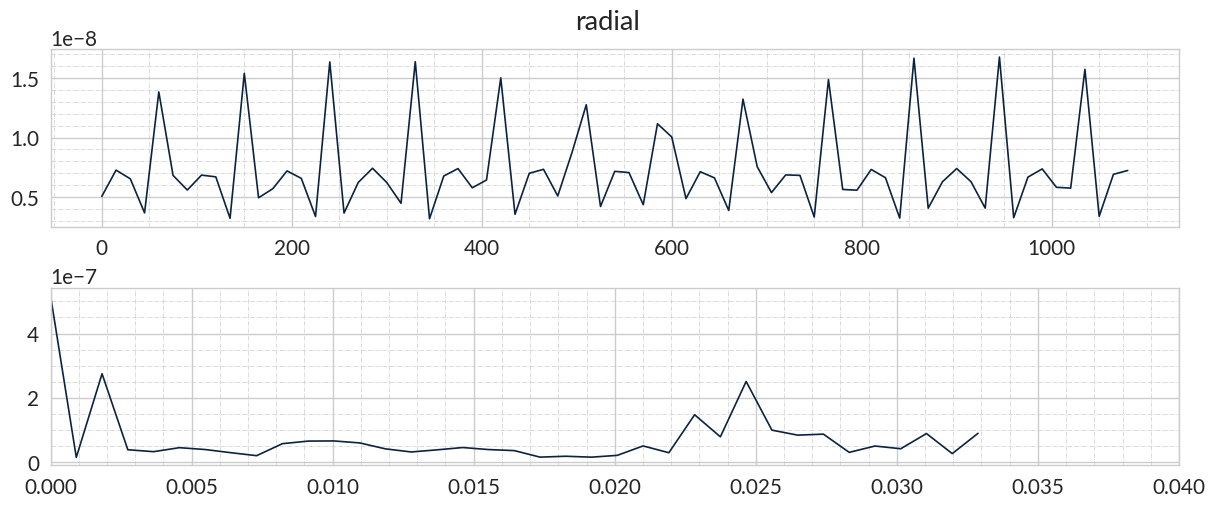

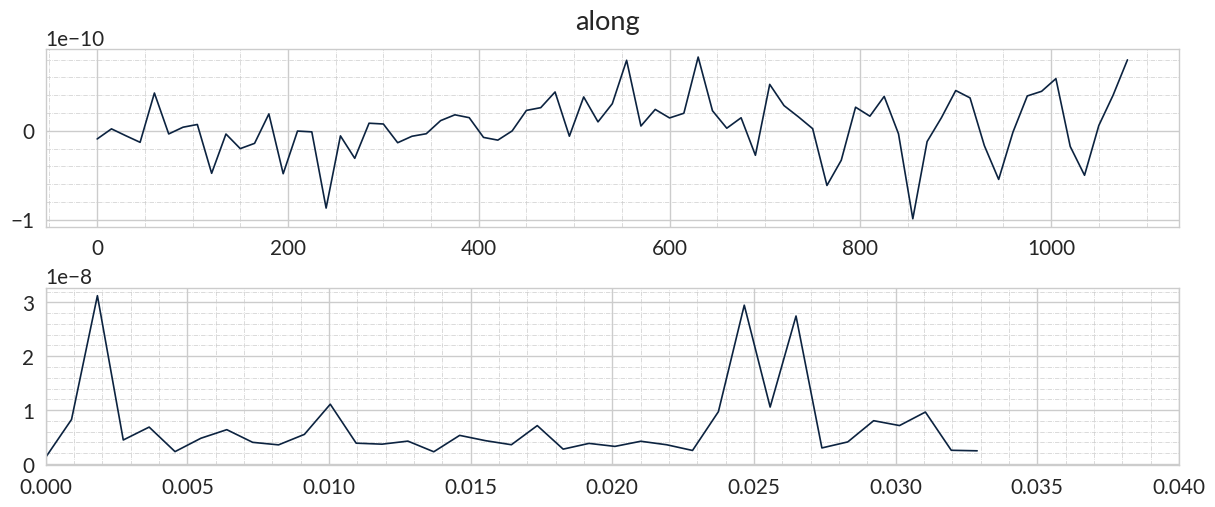

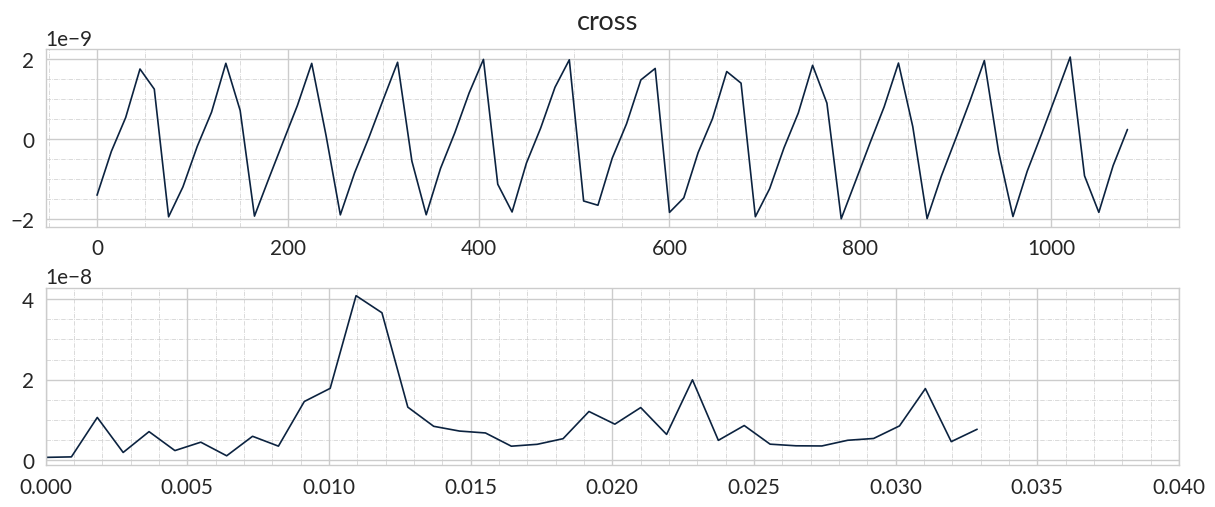

In [29]:
plot_mercury_acc_long(df_long, "radial", trim_years=3)
plot_mercury_acc_long(df_long, "along", trim_years=3)
plot_mercury_acc_long(df_long, "cross", trim_years=3)